In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from imblearn.over_sampling import RandomOverSampler 

In [2]:
df = pd.read_csv('bank-additional.csv', sep=';')
# Prints the number of samples (rows) in the DataFrame
print ('Number of samples: ',len(df))

Number of samples:  4119


Data Cleaning(Handing Missing Values)

In [3]:
# Handle missing values
df = df.replace('unknown', np.nan)
df = df.replace('nonexistent', np.nan)

# Print the count of missing values for each column
print("\nMissing values:")
print(df.isnull().sum())

# Drop columns with high missing values or columns that are not useful for modeling
df = df.drop(["day_of_week", "month", "default", "euribor3m"], axis='columns')

# Handle missing values by filling them with the mode (most frequent value) of each respective column
df['job'].fillna(df['job'].mode()[0], inplace=True)
df['education'].fillna(df['education'].mode()[0], inplace=True)
df['marital'].fillna(df['marital'].mode()[0], inplace=True)
df['housing'].fillna(df['housing'].mode()[0], inplace=True)
df['loan'].fillna(df['loan'].mode()[0], inplace=True)
df['poutcome'].fillna(df['poutcome'].mode()[0], inplace=True)

# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print("\nNumber of duplicate rows:", len(duplicate_rows))



Missing values:
age                  0
job                 39
marital             11
education          167
default            803
housing            105
loan               105
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome          3523
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64

Number of duplicate rows: 1


In [4]:
# Separate features X and target variable y
X = df.drop('y', axis=1)
y = df['y']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Prints the count of "yes" and "no"s
print(y.value_counts())

no     3668
yes     451
Name: y, dtype: int64


As seen above we have an imbalanced dataset. Therefore we prefer doing oversampling to get a balanced dataset

In [6]:
from imblearn.over_sampling import RandomOverSampler 

X = df.drop(columns=['y'])  # Assuming 'y' is the target variable
y = df['y']
class_counts = y.value_counts()
ratio = class_counts['no'] / class_counts['yes']
if ratio > 1:
    oversampler = RandomOverSampler(sampling_strategy={'yes': class_counts['no']})
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    df = pd.concat([X_resampled, y_resampled], axis=1)
    print ('Number of samples: ',len(df))

#checking number of "yes" and "no"'s
print(y.value_counts())



Number of samples:  7336
no     3668
yes     451
Name: y, dtype: int64


Data Preprocessing:

In [7]:
# Define lists of categorical and numerical columns
categorical_cols = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']
numerical_cols = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'nr.employed', 'duration']

# Encode categorical variables using one-hot encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Perform feature scaling on numerical columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded[numerical_cols])

# Combine scaled numerical features and encoded categorical features
X_final = np.concatenate([X_scaled, X_encoded.drop(columns=numerical_cols).values], axis=1)

# Split the data into training and testing sets for better performance
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)


Training set: (3295, 31)
Testing set: (824, 31)


Feature selection

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif

# Perform feature selection using SelectKBest and ANOVA F-value
feature_selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = feature_selector.fit_transform(X_train, y_train)
X_test_selected = feature_selector.transform(X_test)


Model Selection:
For model selection, we compare the performance of three different models: logistic regression, random forest, and a neural network to find the best one.

In [9]:
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize and train logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred_logistic = logistic_model.predict(X_test_selected)

# Evaluate the logistic regression model
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logistic))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

          no       0.92      0.97      0.95       732
         yes       0.62      0.37      0.46        92

    accuracy                           0.90       824
   macro avg       0.77      0.67      0.70       824
weighted avg       0.89      0.90      0.89       824



In [10]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

# Initialize and train random forest classifier
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred_rf = random_forest_model.predict(X_test_selected)

# Evaluate the random forest model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

          no       0.93      0.95      0.94       732
         yes       0.52      0.42      0.47        92

    accuracy                           0.89       824
   macro avg       0.72      0.69      0.70       824
weighted avg       0.88      0.89      0.89       824



In [11]:
#neural network
from sklearn.neural_network import MLPClassifier

# Initialize and train neural network classifier
nn_model = MLPClassifier()
nn_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred_nn = nn_model.predict(X_test_selected)

# Evaluate the neural network model
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))


Neural Network Classification Report:
              precision    recall  f1-score   support

          no       0.93      0.96      0.94       732
         yes       0.57      0.41      0.48        92

    accuracy                           0.90       824
   macro avg       0.75      0.69      0.71       824
weighted avg       0.89      0.90      0.89       824



In [12]:
from sklearn.metrics import accuracy_score

# Assuming y_pred_lr, y_pred_rf, and y_pred_nn contain the predicted labels for each model
accuracy_lr = accuracy_score(y_test, y_pred_logistic)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_nn = accuracy_score(y_test, y_pred_nn)


Evaluating models

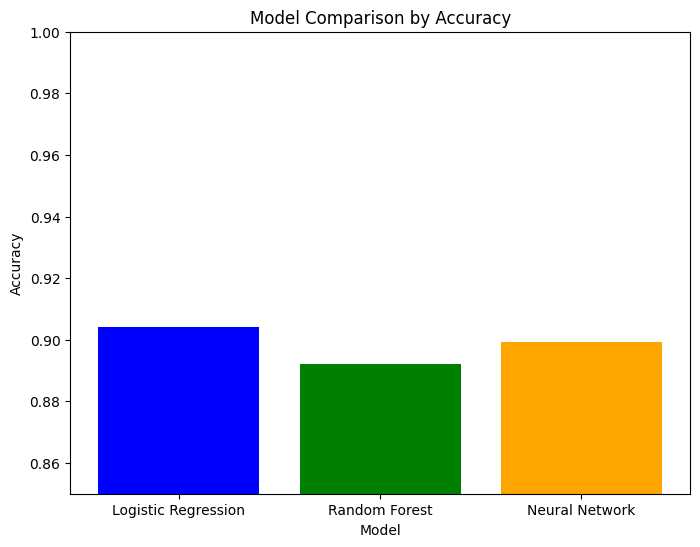

In [13]:
import matplotlib.pyplot as plt

# Define model names and their accuracies
model_names = ['Logistic Regression', 'Random Forest', 'Neural Network']
accuracies = [accuracy_lr, accuracy_rf, accuracy_nn]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison by Accuracy')
plt.ylim(0.85, 1.0)  # Set y-axis limits to ensure clear visualization of differences
plt.show()


We selected Random Forest and proceed with hyperparameter tuning for the Random Forest model

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Define the hyperparameter grid to search over
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform Grid Search CV with 5-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search_rf.fit(X_train, y_train)

# Get the best hyperparameters
best_params_rf = grid_search_rf.best_params_
print("Best Hyperparameters for Random Forest:", best_params_rf)

# Get the best model
best_rf_model = grid_search_rf.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = metrics.accuracy_score(y_test, y_pred_rf)
print("Accuracy of Random Forest:", accuracy_rf)

# Other evaluation metrics (classification report, confusion matrix, etc.)
print(metrics.classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, y_pred_rf))


Best Hyperparameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy of Random Forest: 0.9016990291262136
              precision    recall  f1-score   support

          no       0.92      0.97      0.95       732
         yes       0.60      0.36      0.45        92

    accuracy                           0.90       824
   macro avg       0.76      0.66      0.70       824
weighted avg       0.89      0.90      0.89       824

Confusion Matrix:
[[710  22]
 [ 59  33]]


In [15]:
import joblib
from sklearn.ensemble import RandomForestClassifier

def train_and_save_model(X_train, y_train, best_params):
    # Define and train the Random Forest model with the best hyperparameters
    final_model = RandomForestClassifier(**best_params, random_state=42)  
    final_model.fit(X_train, y_train)
    
    # Save the trained model to a file
    filename = 'bank-additional.sav'
    with open(filename, 'wb') as file:
        joblib.dump(final_model, file)
    
    return filename

# Example usage:
# Assuming you have X_train, y_train, and best_params_rf defined elsewhere
resulting_file = train_and_save_model(X_train, y_train, best_params_rf)
print("Model saved to:",resulting_file )


Model saved to: bank-additional.sav
